In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [329]:
# import pandas library
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.model_selection import train_test_split
#from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats

In [214]:
df3 = pd.read_csv('/content/drive/MyDrive/Data/dk_orig.csv')
df3.drop(columns = 'end', inplace = True)
df3.rename(columns = {'start': 'date'}, inplace = True)
df3.isetitem(df3.columns.get_loc('date'), pd.to_datetime(df3.loc[:,'date']))
df3.head()

,date,load
0,2015-01-01 00:00:00+00:00,3211.0
1,2015-01-01 01:00:00+00:00,3100.0
2,2015-01-01 02:00:00+00:00,2980.0
3,2015-01-01 03:00:00+00:00,2933.0
4,2015-01-01 04:00:00+00:00,2942.0


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Data/dk.csv')
print(df.head())
print('\n')
print(df.tail())
print('\n')
print(df.dtypes)
print(df.shape)

                       start                        end    load
0  2018-01-01 00:00:00+00:00  2018-01-01 01:00:00+00:00  3308.0
1  2018-01-01 01:00:00+00:00  2018-01-01 02:00:00+00:00  3118.0
2  2018-01-01 02:00:00+00:00  2018-01-01 03:00:00+00:00  3018.0
3  2018-01-01 03:00:00+00:00  2018-01-01 04:00:00+00:00  2916.0
4  2018-01-01 04:00:00+00:00  2018-01-01 05:00:00+00:00  2802.0


                           start                        end    load
22627  2020-07-31 19:00:00+00:00  2020-07-31 20:00:00+00:00  3353.0
22628  2020-07-31 20:00:00+00:00  2020-07-31 21:00:00+00:00  3242.0
22629  2020-07-31 21:00:00+00:00  2020-07-31 22:00:00+00:00  3015.0
22630  2020-07-31 22:00:00+00:00  2020-07-31 23:00:00+00:00  2813.0
22631  2020-07-31 23:00:00+00:00  2020-08-01 00:00:00+00:00  2695.0


start     object
end       object
load     float64
dtype: object
(22632, 3)


In [4]:
df.drop(columns = 'end', inplace = True)

In [5]:
df.rename(columns = {'start': 'date'}, inplace = True)
#convert data type to datetime
df.isetitem(df.columns.get_loc('date'), pd.to_datetime(df.loc[:,'date']))
print(df.dtypes)
print('\n')
# check for missing values
print(df.isna().sum())
print(df.head())

date    datetime64[ns, UTC]
load                float64
dtype: object


date    0
load    0
dtype: int64
                       date    load
0 2018-01-01 00:00:00+00:00  3308.0
1 2018-01-01 01:00:00+00:00  3118.0
2 2018-01-01 02:00:00+00:00  3018.0
3 2018-01-01 03:00:00+00:00  2916.0
4 2018-01-01 04:00:00+00:00  2802.0


In [6]:
#check for invalid values
df.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())


date    True
load    True
dtype: bool

In [7]:
df.describe()

,load
count,22632.000000
mean,3834.388256
std,722.150368
min,1693.000000
25%,3258.000000
50%,3798.000000
75%,4389.000000
max,9618.000000


(array([1.100e+02, 5.735e+03, 7.774e+03, 6.853e+03, 2.152e+03, 3.000e+00,
        1.000e+00, 3.000e+00, 0.000e+00, 1.000e+00]),
 array([1693. , 2485.5, 3278. , 4070.5, 4863. , 5655.5, 6448. , 7240.5,
        8033. , 8825.5, 9618. ]),
 <BarContainer object of 10 artists>)

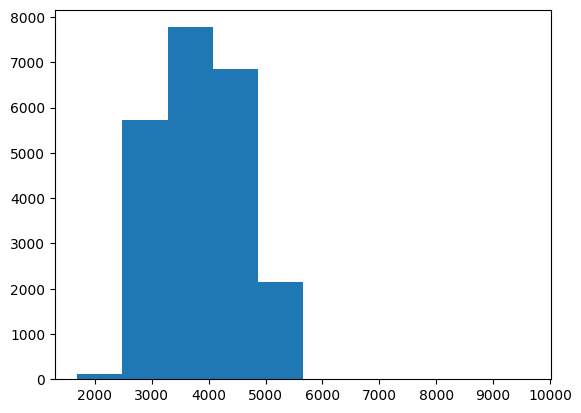

In [8]:
plt.hist(df['load'])

<Axes: >

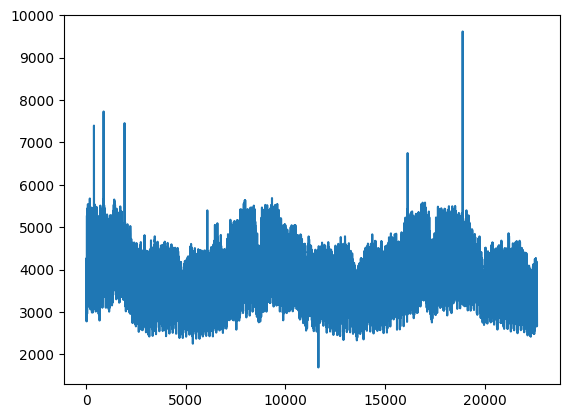

In [9]:
df['load'].plot()

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa60b9ae080>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa60b9ae5c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa60b9adde0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa60b9aeb00>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa60b9aeda0>],
 'means': []}

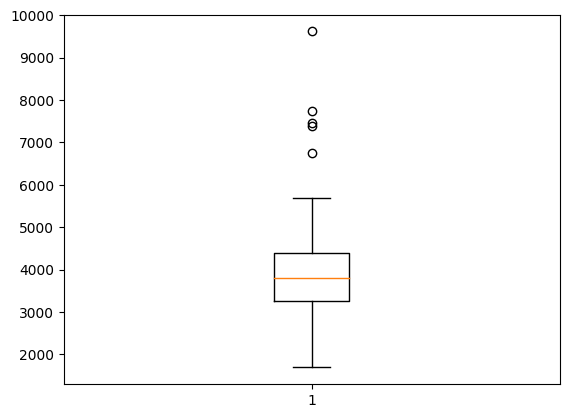

In [10]:
plt.boxplot(df['load'])

In [11]:
# stationarity test
df_stationarityTest = adfuller(df['load'], autolag='AIC')
print("P-value: ", df_stationarityTest[1])

P-value:  1.2076198486621206e-21


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


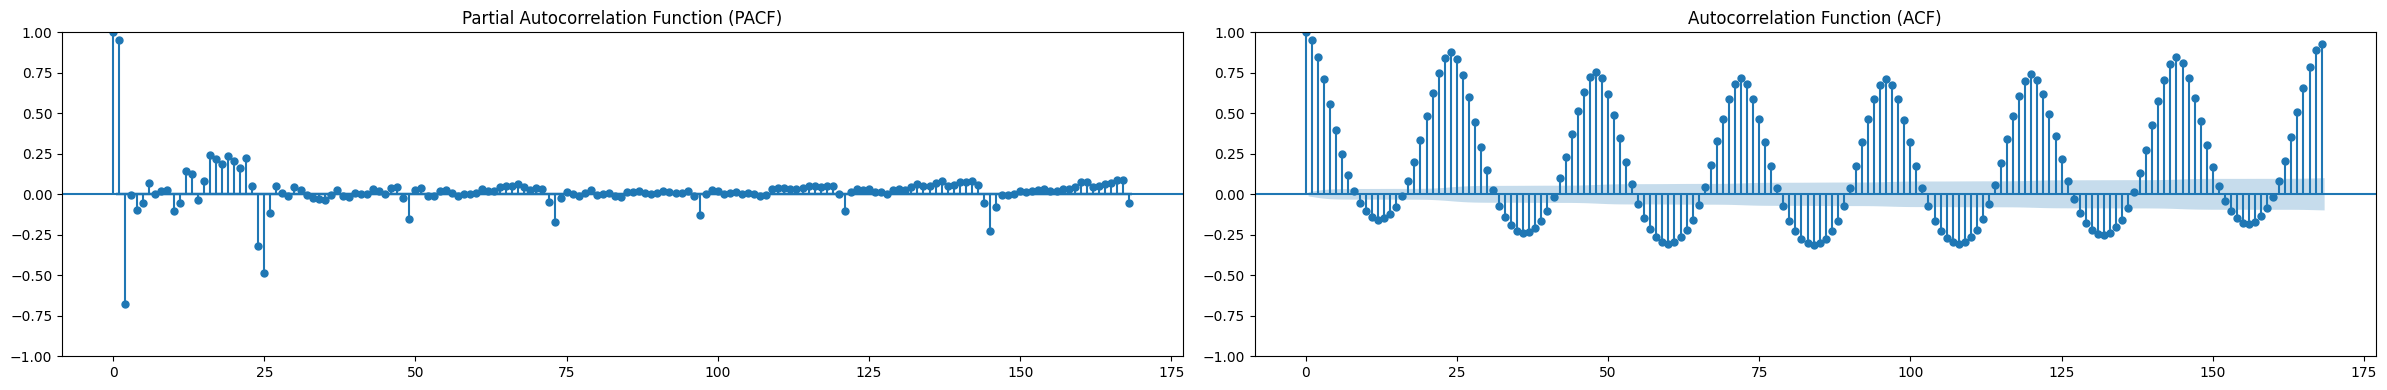

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 4))
# Plot PACF 
plot_pacf(df['load'], lags=168, ax=ax1)
ax1.set_title('Partial Autocorrelation Function (PACF)')
# Plot ACF
plot_acf(df['load'], lags=168, ax=ax2)
ax2.set_title('Autocorrelation Function (ACF)')

plt.tight_layout()
plt.show()

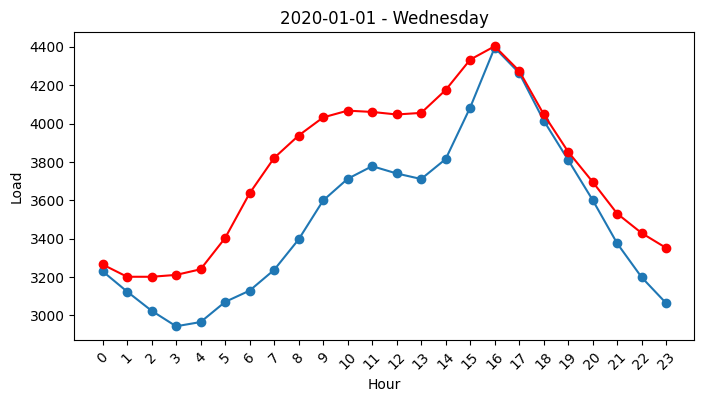

In [21]:
init_start_date = pd.to_datetime("2018-01-01 00:00:00+00:00")
init_end_date = pd.to_datetime("2019-12-31 23:00:00+00:00")
n = 24
window_size = 17520

train_start_index = df.index[df['date'] == init_start_date][0]
train_end_index = df.index[df['date'] == init_end_date][0]
train_data, test_data  = train_test_split(df.iloc[train_start_index : train_end_index + n + 1], train_size =window_size, test_size = n, shuffle = False)

ar_model = AutoReg(train_data['load'], lags=24).fit()
pred = ar_model.predict(start = train_end_index +1, end = train_end_index + n+1, dynamic=False)

plt.figure(figsize=(8,4))
plt.plot(test_data['date'].dt.hour,test_data['load'], marker = 'o')
plt.plot(test_data['date'].dt.hour,pred[0:24], color='red', marker = 'o')
plt.xticks(test_data['date'].dt.hour, rotation = 45)
plt.title(test_data.iloc[0 ,0].strftime("%Y-%m-%d") + " - " + test_data['date'].dt.strftime("%A").iloc[0])
plt.xlabel("Hour")
plt.ylabel("Load")
plt.show()

In [268]:
#rolling window prediction
step_size = 24  # Move the window forward by 24 hours

results = pd.DataFrame(columns=['timestamp', 'actual_load', 'predicted_load'])

for i in range(window_size, window_size + 24*31, step_size):
    # Extract the training data for the current window
    train_data = df.iloc[i - window_size:i]
    train_data.reset_index(drop = True, inplace = True)
    # Fit the AR model to the training data
    ar_model = AutoReg(train_data['load'], lags=24).fit()

    # Make predictions for the next 24 hours
    start_index = train_data.index[-1] + 1
    end_index = start_index + step_size - 1
    pred = ar_model.predict(start=start_index, end=end_index, dynamic=False)

    # Extract the timestamp and actual load for the next 24 hours
    next_24_hours = df.iloc[i :i + step_size]

    #reset indicies so the data can be appended
    next_24_hours.reset_index(drop = True, inplace = True)
    pred.reset_index(drop = True, inplace = True)

    # Create a DataFrame with the predicted load for the next 24 hours
    predicted_data = pd.DataFrame({'timestamp': next_24_hours['date'],
                                   'actual_load': next_24_hours['load'],
                                   'predicted_load': pred})
    # Append the predicted data to the results DataFrame
    results = pd.concat([results, predicted_data], ignore_index=True)

In [316]:
results

,timestamp,actual_load,predicted_load
0,2020-01-01 00:00:00+00:00,3230.0,3265.212315
1,2020-01-01 01:00:00+00:00,3124.0,3201.226559
2,2020-01-01 02:00:00+00:00,3024.0,3201.128172
3,2020-01-01 03:00:00+00:00,2943.0,3210.937308
4,2020-01-01 04:00:00+00:00,2965.0,3240.303473
...,...,...,...
739,2020-01-31 19:00:00+00:00,4270.0,4528.170104
740,2020-01-31 20:00:00+00:00,3962.0,4313.009472
741,2020-01-31 21:00:00+00:00,3760.0,4021.568275
742,2020-01-31 22:00:00+00:00,3477.0,3767.523423


In [324]:
results['timestamp'].dt.date

0      2020-01-01
1      2020-01-01
2      2020-01-01
3      2020-01-01
4      2020-01-01
          ...    
739    2020-01-31
740    2020-01-31
741    2020-01-31
742    2020-01-31
743    2020-01-31
Name: timestamp, Length: 744, dtype: object

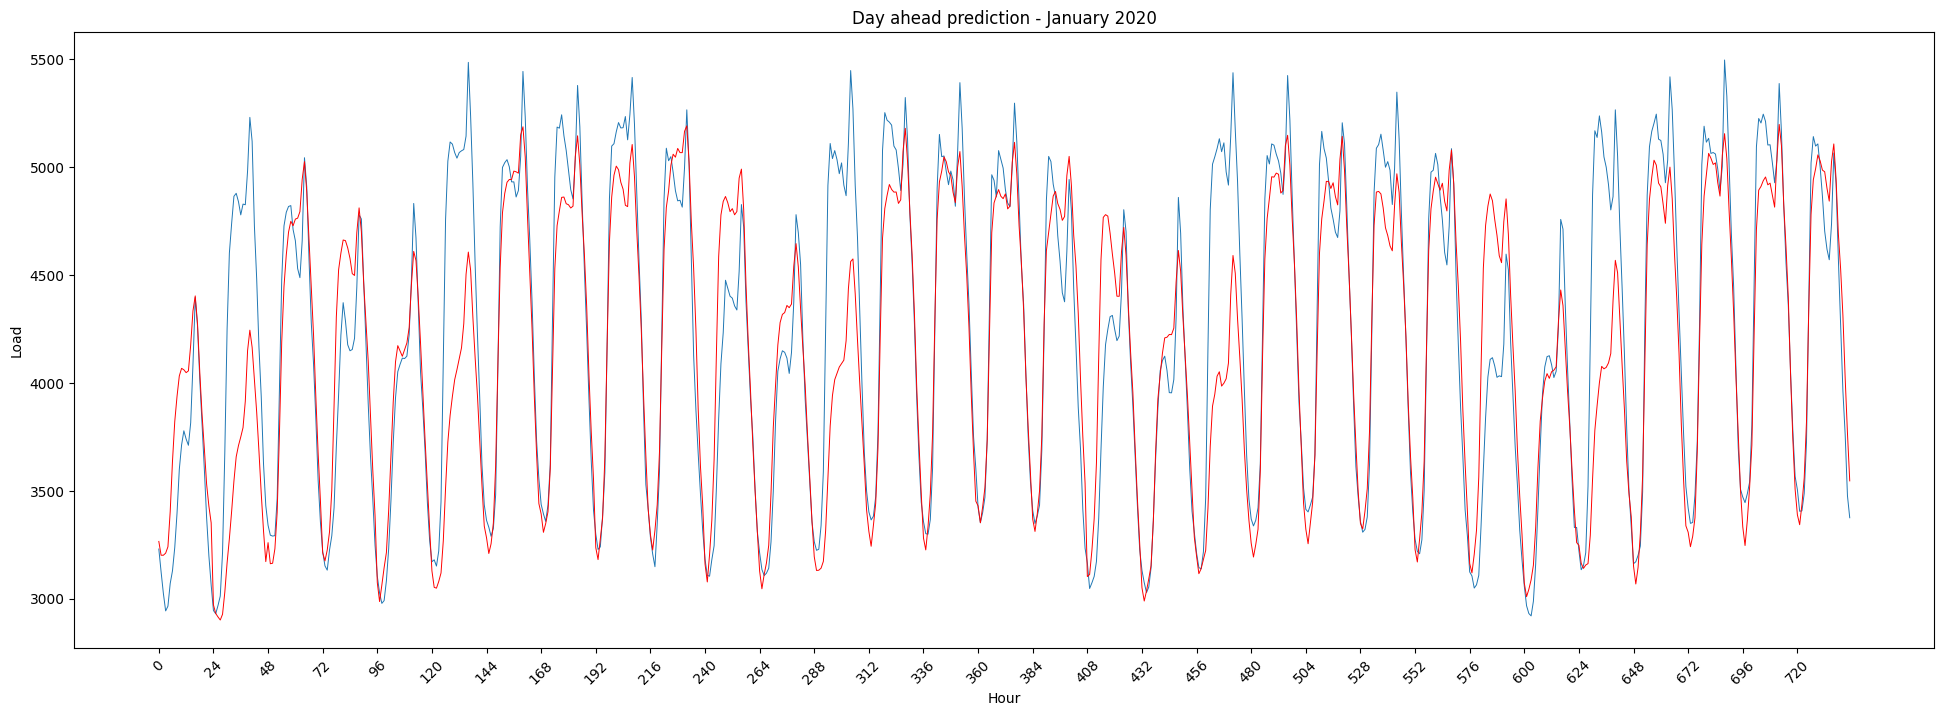

In [337]:
results.isetitem(results.columns.get_loc('timestamp'), pd.to_datetime(results.loc[:,'timestamp']))
x=list(results.index)

plt.figure(figsize=(24,8))
plt.plot(x,results['actual_load'], linewidth=0.7)
plt.plot(x,results['predicted_load'], color='red', linewidth=0.7)
plt.xticks(np.arange(0,744,24), rotation = 45, fontsize=10)
plt.title("Day ahead prediction - January 2020")
plt.xlabel("Hour")
plt.ylabel("Load")
plt.show()

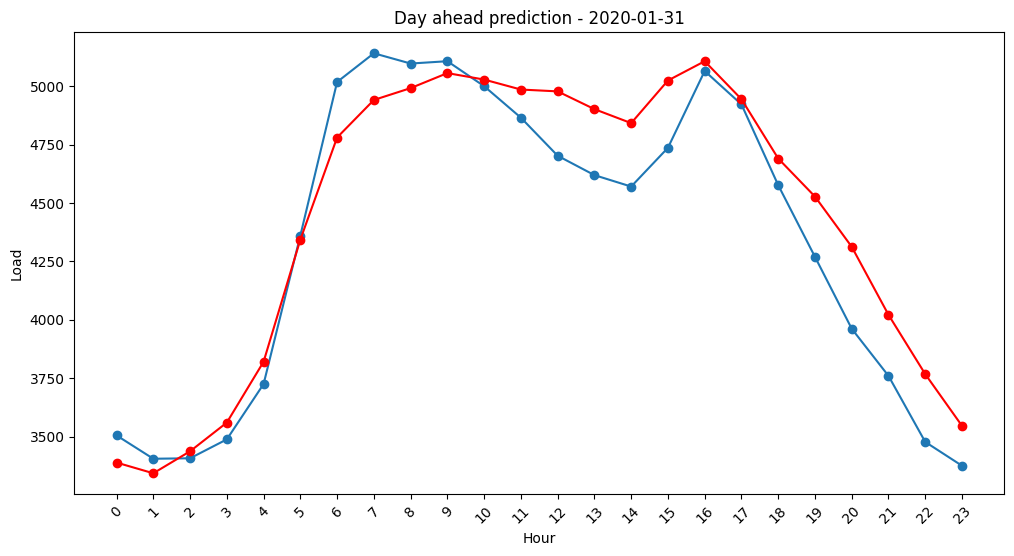

In [338]:
results.isetitem(results.columns.get_loc('timestamp'), pd.to_datetime(results.loc[:,'timestamp']))

plt.figure(figsize=(12,6))
plt.plot(results.tail(24)['timestamp'].dt.hour,results.tail(24)['actual_load'], marker = 'o')
plt.plot(results.tail(24)['timestamp'].dt.hour,results.tail(24)['predicted_load'], color='red', marker = 'o')
plt.xticks(results.tail(24)['timestamp'].dt.hour, rotation = 45)
plt.title("Day ahead prediction - 2020-01-31")
plt.xlabel("Hour")
plt.ylabel("Load")
plt.show()